# Trabajo Práctico Integrador - Visión por Computadora II
Carrera de Especialización en Inteligencia Artificial - FIUBA

**Integrantes:**
- Juan Ruiz Otondo
- Gonzalo Fernández
- Maria Fabiana Cid

**Objetivo:** Realizar un modelo para la clasificación de residuos para reciclaje basándose en el dataset [TrashNet](https://www.kaggle.com/datasets/feyzazkefe/trashnet).

## Requerimientos
Requisitos para la correcta ejecución del notebook:

- Entorno virtual de python con paquetes instalados, posible mediante la ejecución de los siguientes comandos:

```bash
python -m venv .venv
source .venv/bin/activate
pip install -r requirements.txt
```

- Credenciales de kaggle para descarga del dataset. Más información en el README del siguiente repositorio: https://github.com/Kaggle/kagglehub

In [3]:
from collections import Counter
import copy
import os
import kagglehub
import matplotlib.pyplot as plt
import optuna
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
)
from PIL import Image
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision import datasets, transforms
from torchvision.models import ResNet18_Weights, resnet18

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## Baseline para clasificador
Para el baseline del proyecto se seleccionó una arquitectura ResNet18. La selección fue motivada por las siguientes características: 
- Es ligero y se entrena rápidamente.
- Tiene un buen rendimiento en conjuntos de datos pequeños y medianos.
- Está disponible directamente a través de torchvision.models.
- Admite aprendizaje por transferencia.

### Carga y preprocesamiento del dataset

Carga y preprocesamiento del dataset TrashNet. Más información sobre el EDA del dataset en [02-trashnet-baseline.ipynb](./02-trashnet-baseline.ipynb)

In [4]:
dataset_path = kagglehub.dataset_download("feyzazkefe/trashnet", force_download=True)
print("Path to dataset files:", dataset_path)
dataset_path = os.path.join(dataset_path, "dataset-resized")

full_dataset = datasets.ImageFolder(root=dataset_path)
class_names = full_dataset.classes
num_classes = len(class_names)
print(f"Classes: {class_names}")

100%|██████████| 40.8M/40.8M [00:07<00:00, 5.72MB/s]

Extracting files...


Path to dataset files: /home/ggf/.cache/kagglehub/datasets/feyzazkefe/trashnet/versions/1
Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


En el EDA se detectó un desbalance de clases (la clase "trash" no esta tan representada como el resto). Se corrige mediante la aplicación de data augmentation.

Con este objetivo, definimos una clase que hereda de la clase base dataset para metermitir aplicaciones orientadas para cada clase.

In [5]:
class ClassAugmentDataset(Dataset):
    def __init__(self, samples, default_transform):
        self.samples = samples
        self.default_transform = default_transform

    def __getitem__(self, index):
        image, label = self.samples[index]
        return self.default_transform(image), label

    def __len__(self):
        return len(self.samples)

Definimos la una transformación para la clase "trash" con data augmentation y otra default. Para validación no se aplica ningun tipo de data augmentation.

In [ ]:
train_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(25),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

test_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

NOTA: Se experimentó con resize 224x224 y normalización equivalente a la utiliada por ImageNet (con el cual se entrena ResNet18) pero el desempeño del modelo es menor. 

Creamos un sampler para los datos de entrenamiento y definimos las transformaciones por clase.

In [10]:
class_counts = Counter([label for _, label in full_dataset.samples])
print("Class counts:", class_counts)

class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}
sample_weights = [class_weights[label] for _, label in full_dataset.samples]

Class counts: Counter({3: 594, 1: 501, 4: 482, 2: 410, 0: 403, 5: 137})


1. División del dataset en datos para entrenamiento y datos de validación.
2. Aplicación de transformaciones definidas previamente.
3. Creación de sampler para datos de training
4. Creación de data loaders.

In [11]:
def get_dataloaders(
    dataset, train_transform, val_transform, batch_size, use_sampler=False
):
    """Get dataloaders for training and validation."""
    train_samples, val_samples = torch.utils.data.random_split(dataset, [0.8, 0.2])

    train_dataset = ClassAugmentDataset(
        train_samples, default_transform=train_transform
    )
    val_dataset = ClassAugmentDataset(val_samples, default_transform=val_transform)

    train_labels = [label for _, label in train_samples]
    class_counts = Counter(train_labels)
    class_weights = {
        cls: len(train_labels) / count for cls, count in class_counts.items()
    }
    sample_weights = [class_weights[lbl] for lbl in train_labels]

    train_sampler = None
    if use_sampler:
        train_sampler = WeightedRandomSampler(
            sample_weights, num_samples=len(sample_weights), replacement=True
        )

    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=4
    )
    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, num_workers=4
    )
    return train_loader, val_loader

Se realiza un breve chequeo para comprobar la correcta aplicación del data augmentation.

In [16]:
train_loader, val_loader = get_dataloaders(
    full_dataset, train_transform, test_transform, batch_size=32, use_sampler=False
)

label_counter = Counter()
for _, labels in train_loader:
    label_counter.update(labels.tolist())

for cls_idx, count in label_counter.items():
    print(f"Class '{class_names[cls_idx]}': {count} samples")

Class 'plastic': 397 samples
Class 'metal': 334 samples
Class 'cardboard': 317 samples
Class 'paper': 473 samples
Class 'trash': 101 samples
Class 'glass': 400 samples


In [17]:
train_loader, val_loader = get_dataloaders(
    full_dataset, train_transform, test_transform, batch_size=32, use_sampler=True
)

label_counter = Counter()
for _, labels in train_loader:
    label_counter.update(labels.tolist())

for cls_idx, count in label_counter.items():
    print(f"Class '{class_names[cls_idx]}': {count} samples")

Class 'trash': 315 samples
Class 'paper': 333 samples
Class 'metal': 342 samples
Class 'plastic': 365 samples
Class 'glass': 320 samples
Class 'cardboard': 347 samples


### Definición del modelo baseline
A continuación se carga el modelo pre-entrenado ResNet18 y se congelan las capas previas:

In [18]:
def create_empty_model(num_classes):
    model = resnet18(weights=ResNet18_Weights.DEFAULT)
    for param in model.parameters():
        param.requires_grad = False

    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model


model = create_empty_model(num_classes=num_classes)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

### Entrenamiento y validación del modelo baseline

Definición del esquema de entrenamiento y validación.

In [19]:
def train_validate(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs=10,
    scheduler=None,
    verbose=False,
):
    """Train and validate the model."""
    model.to(device)
    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        preds, targets = [], []

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds.extend(outputs.argmax(dim=1).cpu().numpy())
            targets.extend(labels.cpu().numpy())

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = accuracy_score(targets, preds)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        model.eval()
        val_loss = 0.0
        val_preds, val_targets = [], []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                val_preds.extend(outputs.argmax(dim=1).cpu().numpy())
                val_targets.extend(labels.cpu().numpy())

        val_loss /= len(val_loader.dataset)
        val_acc = accuracy_score(val_targets, val_preds)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        if verbose:
            print(
                f"Epoch {epoch+1}/{epochs} | "
                f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
                f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
            )

        if val_acc > best_acc:  # save the best model
            precision = precision_score(
                val_targets, val_preds, average="macro", zero_division=0
            )
            recall = recall_score(
                val_targets, val_preds, average="macro", zero_division=0
            )
            f1 = f1_score(val_targets, val_preds, average="macro", zero_division=0)
            cm = confusion_matrix(val_targets, val_preds)
            cm_normalized = cm.astype("float") / cm.sum(axis=1, keepdims=True)

            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            metrics = {
                "precision": precision,
                "recall": recall,
                "f1_score": f1,
                "accuracy": val_acc,
                "confusion_matrix": cm_normalized,
                "val_targets": val_targets,
                "val_preds": val_preds,
            }

        if scheduler is not None:
            scheduler.step()

    if verbose:
        print(f"Best accuracy: {best_acc:.4f}")
    model.load_state_dict(best_model_wts)

    return model, train_losses, val_losses, train_accuracies, val_accuracies, metrics

### Entrenamiento y validation sin data augmentation
Ejecución del entrenamiento y validación:

In [21]:
train_loader, val_loader = get_dataloaders(
    full_dataset, train_transform, test_transform, batch_size=32, use_sampler=False
)

model = create_empty_model(num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

model, train_losses, val_losses, train_accuracies, val_accuracies, metrics = (
    train_validate(
        model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        device,
        epochs=15,
        scheduler=scheduler,
        verbose=True,
    )
)

Epoch 1/15 | Train Loss: 0.0449, Train Acc: 0.4624 | Val Loss: 1.1286, Val Acc: 0.6119
Epoch 2/15 | Train Loss: 0.0309, Train Acc: 0.6830 | Val Loss: 0.9477, Val Acc: 0.6574
Epoch 3/15 | Train Loss: 0.0266, Train Acc: 0.7176 | Val Loss: 0.8477, Val Acc: 0.6911
Epoch 4/15 | Train Loss: 0.0244, Train Acc: 0.7359 | Val Loss: 0.7806, Val Acc: 0.7129
Epoch 5/15 | Train Loss: 0.0225, Train Acc: 0.7517 | Val Loss: 0.7507, Val Acc: 0.7386
Epoch 6/15 | Train Loss: 0.0208, Train Acc: 0.7883 | Val Loss: 0.7509, Val Acc: 0.7228
Epoch 7/15 | Train Loss: 0.0205, Train Acc: 0.7864 | Val Loss: 0.7486, Val Acc: 0.7228
Epoch 8/15 | Train Loss: 0.0203, Train Acc: 0.7893 | Val Loss: 0.7388, Val Acc: 0.7307
Epoch 9/15 | Train Loss: 0.0198, Train Acc: 0.7834 | Val Loss: 0.7293, Val Acc: 0.7386
Epoch 10/15 | Train Loss: 0.0192, Train Acc: 0.7977 | Val Loss: 0.7190, Val Acc: 0.7426
Epoch 11/15 | Train Loss: 0.0189, Train Acc: 0.8037 | Val Loss: 0.6840, Val Acc: 0.7644
Epoch 12/15 | Train Loss: 0.0186, Train A

Visualización de resultados:

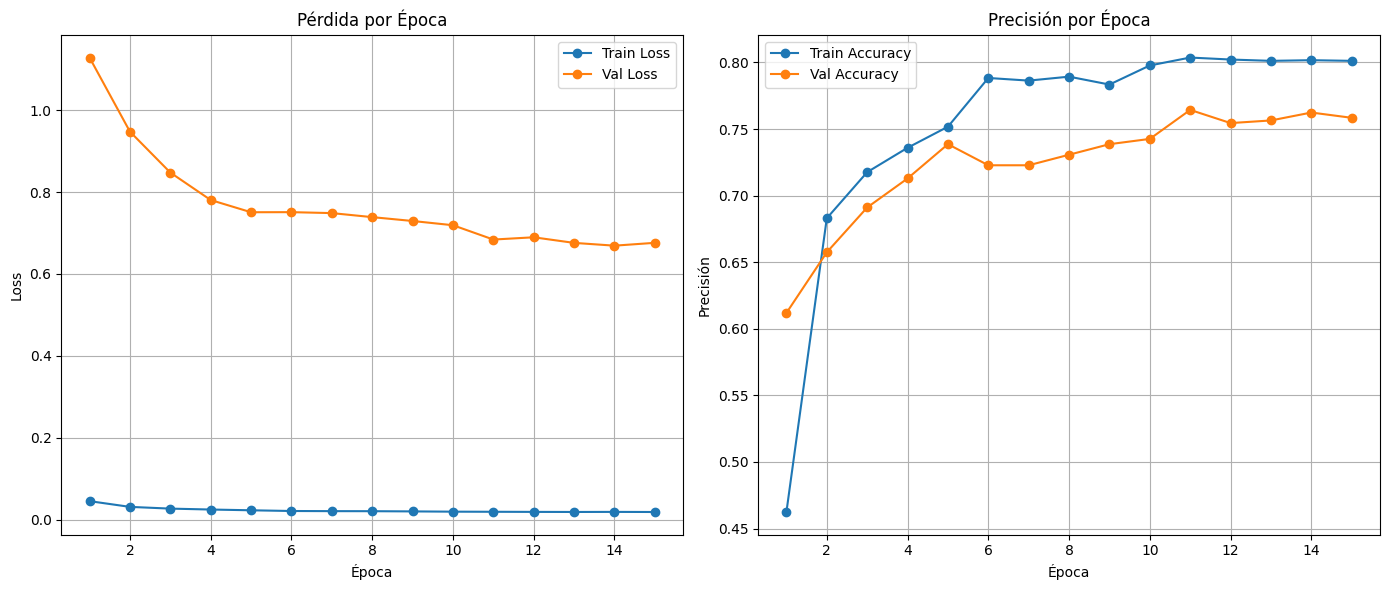

In [22]:
def get_loss_precision_plots(
    train_losses, val_losses, train_accuracies, val_accuracies, ax_loss, ax_accuracy
):
    """Plot training and validation loss and accuracy."""
    epochs_range = range(1, len(train_losses) + 1)

    ax_loss.set_title("Pérdida por Época")
    ax_loss.plot(epochs_range, train_losses, label="Train Loss", marker="o")
    ax_loss.plot(epochs_range, val_losses, label="Val Loss", marker="o")
    ax_loss.set_xlabel("Época")
    ax_loss.set_ylabel("Loss")
    ax_loss.legend()
    ax_loss.grid(True)

    ax_accuracy.set_title("Precisión por Época")
    ax_accuracy.plot(epochs_range, train_accuracies, label="Train Accuracy", marker="o")
    ax_accuracy.plot(epochs_range, val_accuracies, label="Val Accuracy", marker="o")
    ax_accuracy.set_xlabel("Época")
    ax_accuracy.set_ylabel("Precisión")
    ax_accuracy.legend()
    ax_accuracy.grid(True)


fig, axs = plt.subplots(1, 2, figsize=(14, 6))
get_loss_precision_plots(
    train_losses, val_losses, train_accuracies, val_accuracies, axs[0], axs[1]
)
fig.tight_layout()

Resultados:

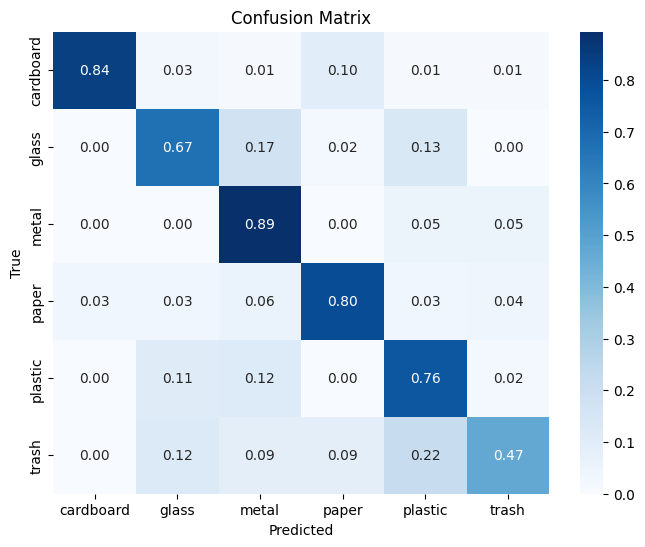

In [23]:
plt.figure(figsize=(8, 6))
sns.heatmap(
    metrics["confusion_matrix"],
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [24]:
print("Classification report:")
print(
    classification_report(metrics["val_targets"], metrics["val_preds"], zero_division=0)
)

Classification report:
              precision    recall  f1-score   support

           0       0.94      0.84      0.89        80
           1       0.78      0.67      0.72       104
           2       0.63      0.89      0.74        75
           3       0.88      0.80      0.84       119
           4       0.71      0.76      0.73        95
           5       0.56      0.47      0.51        32

    accuracy                           0.76       505
   macro avg       0.75      0.74      0.74       505
weighted avg       0.78      0.76      0.77       505



### Entrenamiento y validation con data augmentation
Definición de diferentes transformaciones y ejecución del entrenamiento y validación:

In [ ]:
train_transform0 = transforms.Compose(
    [
        transforms.RandomRotation(25),
        transforms.ToTensor(),
        transforms.Normalize([0.5] * 3, [0.5] * 3),
    ]
)

train_transform1 = transforms.Compose(
    [
        transforms.RandomRotation(25),
        transforms.ToTensor(),
        transforms.Normalize([0.5] * 3, [0.5] * 3),
    ]
)

train_transform2 = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5] * 3, [0.5] * 3),
    ]
)

train_transform3 = transforms.Compose(
    [
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5] * 3, [0.5] * 3),
    ]
)

train_transform4 = transforms.Compose(
    [
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.5] * 3, [0.5] * 3),
    ]
)

train_transform5 = transforms.Compose(
    [
        transforms.RandomRotation(25),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5] * 3, [0.5] * 3),
    ]
)

test_transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize([0.5] * 3, [0.5] * 3)]
)

In [ ]:
train_losses_results = []
val_losses_results = []
train_accuracies_results = []
val_accuracies_results = []
metrics_results = []

for train_transform in [
    train_transform0,
    train_transform1,
    train_transform2,
    train_transform3,
    train_transform4,
]:
    train_loader, val_loader = get_dataloaders(
        full_dataset, train_transform, test_transform, batch_size=32, use_sampler=True
    )

    model = create_empty_model()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    model, train_losses, val_losses, train_accuracies, val_accuracies, metrics = (
        train_validate(
            model,
            train_loader,
            val_loader,
            criterion,
            optimizer,
            device,
            epochs=15,
            scheduler=scheduler,
            verbose=False,
        )
    )

    train_losses_results.append(train_losses)
    val_losses_results.append(val_losses)
    train_accuracies_results.append(train_accuracies)
    val_accuracies_results.append(val_accuracies)
    metrics_results.append(metrics)

Visualización de resultados:

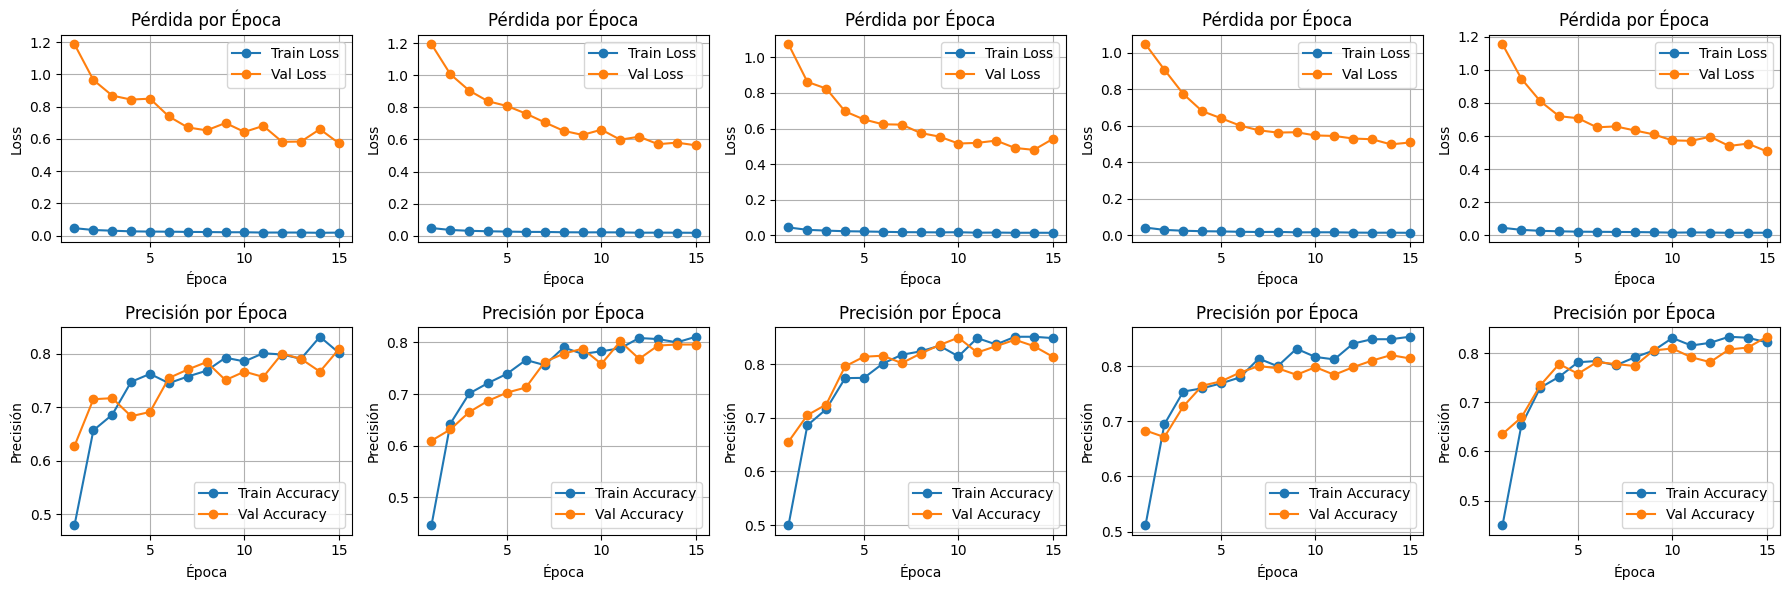

In [ ]:
fig, axs = plt.subplots(2, len(train_losses_results), figsize=(18, 6))
for i, (train_losses, val_losses, train_accuracies, val_accuracies) in enumerate(
    zip(
        train_losses_results,
        val_losses_results,
        train_accuracies_results,
        val_accuracies_results,
    )
):
    get_loss_precision_plots(
        train_losses, val_losses, train_accuracies, val_accuracies, axs[0, i], axs[1, i]
    )
fig.tight_layout()

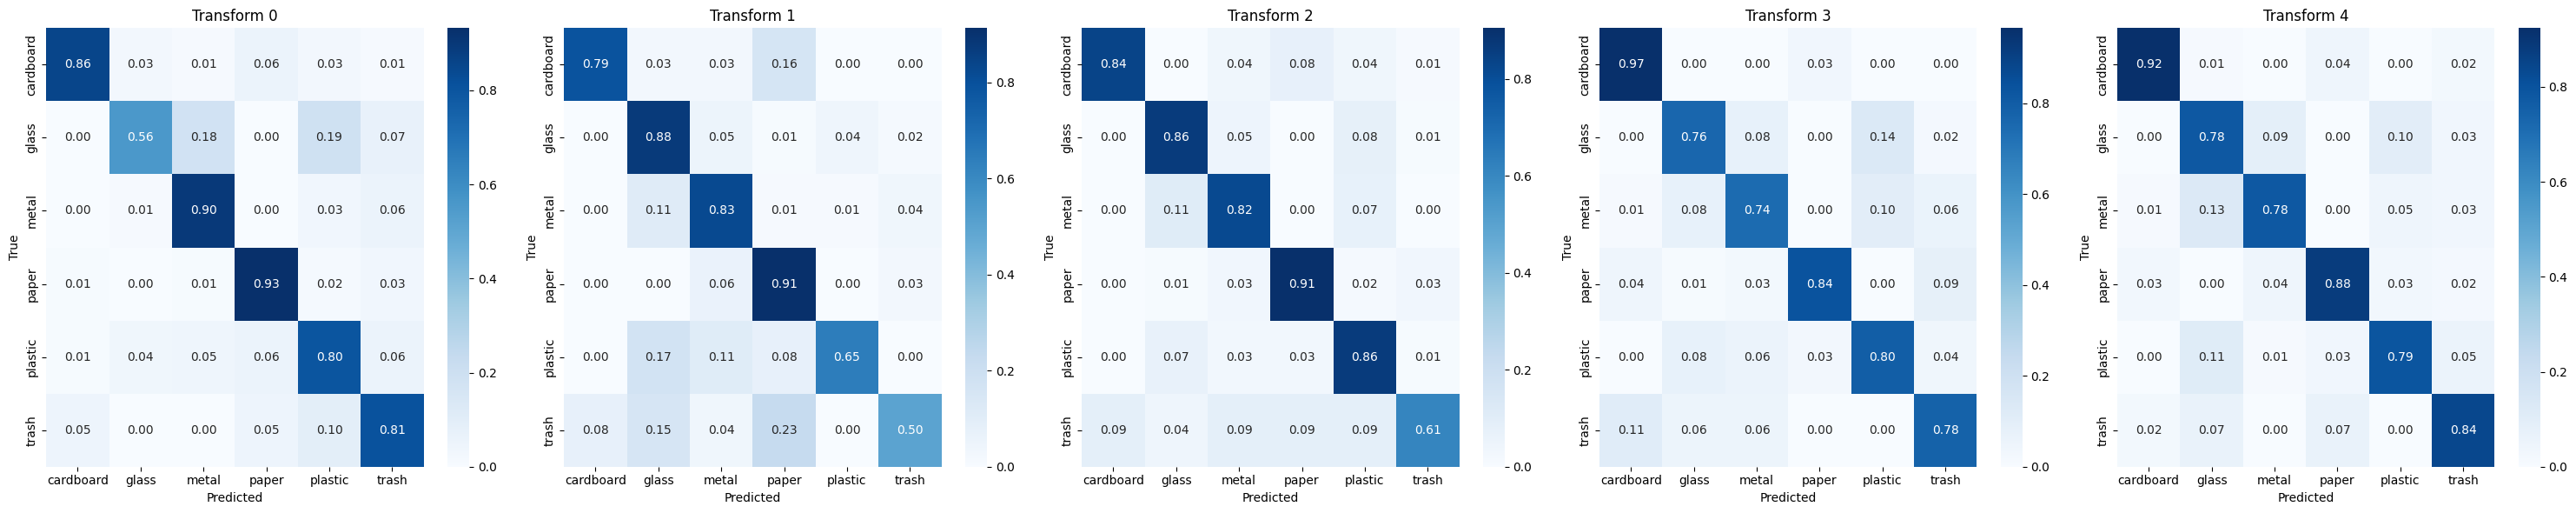

In [70]:
n = len(metrics_results)
fig, axes = plt.subplots(1, n, figsize=(6 * n, 6))

for i in range(n):
    # print(f"Transform {i}:")
    # print("Classification report:")
    # print(
    #     classification_report(
    #         metrics_results[i]["val_targets"],
    #         metrics_results[i]["val_preds"],
    #         zero_division=0,
    #     )
    # )

    ax = axes[i] if n > 1 else axes
    sns.heatmap(
        metrics_results[i]["confusion_matrix"],
        annot=True,
        fmt=".2f",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
        ax=ax,
    )
    ax.set_title(f"Transform {i}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

plt.tight_layout()
plt.show()

Comparando las diferentes matrices de confusión se justifica el uso de las siguientes transformaciones para el data augmentation:
- Espejado random horizontal
- Espejado random vertical
- Rotación random

## Búsqueda de hiperparámetros
Se realiza una búsqueda de hiperparámetros con [Optuna](https://optuna.org/).

Definición de la función objetivo en la búsqueda.

In [ ]:
def objective(trial):
    """Optuna objective function for hyperparameter optimization."""
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64])
    step_size = trial.suggest_int("step_size", 3, 10)
    gamma = trial.suggest_float("gamma", 0.1, 0.9)

    train_transform = transforms.Compose(
        [
            transforms.RandomRotation(25),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.5] * 3, [0.5] * 3),
        ]
    )

    test_transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize([0.5] * 3, [0.5] * 3)]
    )

    train_loader, val_loader = get_dataloaders(
        full_dataset,
        train_transform,
        test_transform,
        batch_size=batch_size,
        use_sampler=False,
    )

    model = create_empty_model()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    model, _, _, _, _, metrics = train_validate(
        model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        device,
        epochs=15,
        scheduler=scheduler,
        verbose=False,
    )

    return metrics["f1_score"]

Ejecución de la búsqueda.

In [74]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

[I 2025-06-04 18:25:10,249] A new study created in memory with name: no-name-c0204aa9-7d3c-451a-a879-9f3af1c48a85
/tmp/ipykernel_78227/3918031927.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
/tmp/ipykernel_78227/3918031927.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-6, 1e-3)
/tmp/ipykernel_78227/3918031927.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform("gamma", 0.1, 0.9)
[I 2

Resultados de la búsqueda de hiperparámetros.

In [90]:
print("Best trial:")
trial = study.best_trial

print(f"  F1 score: {trial.value}")
print("  Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Best trial:
  F1 score: 0.8134532928419761
  Params:
    lr: 0.004367922954598241
    weight_decay: 8.843939602412726e-06
    batch_size: 32
    step_size: 3
    gamma: 0.13565654529804916


### Generación del modelo baseline

In [ ]:
train_transform = transforms.Compose(
    [
        transforms.RandomRotation(25),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5] * 3, [0.5] * 3),
    ]
)

test_transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize([0.5] * 3, [0.5] * 3)]
)

train_loader, val_loader = get_dataloaders(
    full_dataset, train_transform, test_transform, batch_size=32, use_sampler=True
)

model = create_empty_model()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.004367, weight_decay=8.84e-6)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1356)

model, train_losses, val_losses, train_accuracies, val_accuracies, metrics = (
    train_validate(
        model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        device,
        epochs=15,
        scheduler=scheduler,
        verbose=True,
    )
)

Epoch 1/15 | Train Loss: 0.0473, Train Acc: 0.4515 | Val Loss: 0.8387, Val Acc: 0.7168
Epoch 2/15 | Train Loss: 0.0293, Train Acc: 0.6632 | Val Loss: 0.7381, Val Acc: 0.7287
Epoch 3/15 | Train Loss: 0.0251, Train Acc: 0.7141 | Val Loss: 0.6680, Val Acc: 0.7465


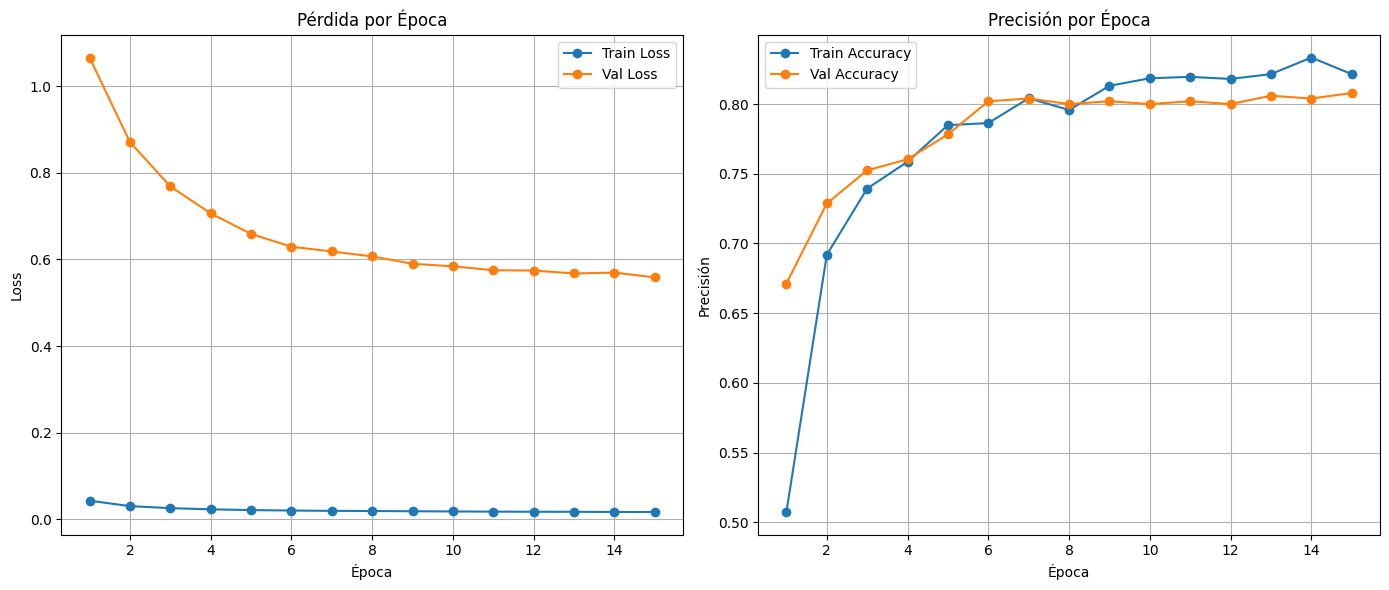

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
get_loss_precision_plots(
    train_losses, val_losses, train_accuracies, val_accuracies, axs[0], axs[1]
)
fig.tight_layout()

Exportación del modelo entrenado.

In [93]:
torch.save(model.state_dict(), "output/trashnet_baseline_model.pth")